# Credit Card Fraud Detection

In this project, we will address the issue of credit card fraud, one of the main concerns of financial institutions such as banks and *fintechs*. In Brazil, about 12.1 million people have been victims of some type of financial fraud in the last year. Translated into values, the financial blows surpassed the figure of BRL 1.8 billion in losses per year for the last 12 months.

Among these frauds, those involving credit cards are of great relevance since their non-detection will result in considerable losses, both for the consumer and for the financial institution.

Another factor to be considered is the amount of false positives, that is, those times when you tried to make a purchase and had your card preemptively blocked - which probably caused stress and embarrassment.

For all these reasons, the investment in the area of ​​fraud detection through Artificial Intelligence has been growing every year, representing a great opportunity in *Data Science*.

With large volumes of data as a historical basis, a machine learning algorithm just a little better than the previous ones already represents a savings of millions of Reais. And that is the challenge, to increasingly improve the use of algorithms aimed at inhibiting or preventing fraudulent transactions.

## Solution Proposal

To solve this problem, we will perform the following tasks:

- **0.0.** Data Colection
- **1.0.** Data Description
- **2.0.** Feature Engineering
- **3.0.** Data Filtering
- **4.0.** Exploratory Data Analysis
- **5.0.** Data Preparation
- **6.0.** Feature Selection
- **7.0.** Machine Learning Modeling
- **9.0.** Translation and Interpretation of the Error
- **10.0.** Deploy Model to Production

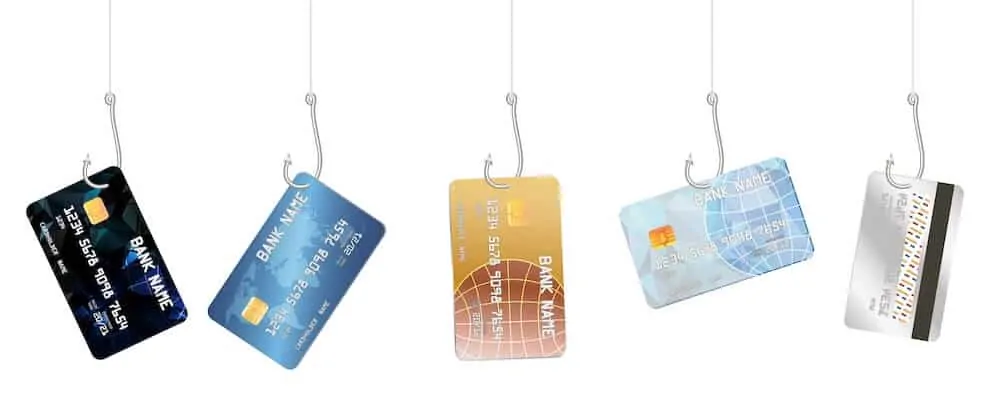

In [3]:
Image('img/card.jpg')

# 0.0. Imports

In [4]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display     import Image

## 0.1. Helper Functions

In this step, i'll documentation all of the functions that we will need to use in the next sections.

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [6]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

The data we will use in this project has been made available by some European credit card companies. The *dataset* represents the financial transactions that took place in the period of two days, where 492 frauds were classified among almost 290 thousand transactions.

As you can see, this is an extremely unbalanced dataset, where fraud represents only 0.17% of the total.

Another interesting detail is that the *features* are all numerical, and have been defaced (due to privacy and security issues). Thus, column names are represented by $[V1, V2, V3 \dots, V28]$.

<p align=center>
<img src="img/atm.jpg" width="50%"></p>

[On the original data page](https://www.kaggle.com/mlg-ulb/creditcardfraud) it is also reported that the variables have gone through a transformation known as Principal Component Analysis (*Principal Component Analysis* - PCA).

PCA allows for dimensionality reduction while maintaining as much information as possible. To achieve this, the algorithm finds a new set of features - called **components**.

These components are less than or equal to the original variables. In the case of this project, the components found by the PCA transformation are the columns $[V1, V2, V3 \dots, V28]$.

In [7]:
file_path = 'https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1'

df_raw = pd.read_csv( file_path )

df_raw.sample()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
99942,67351.0,-2.115997,0.597886,0.05037,-0.594453,-1.366952,0.664806,3.051758,-0.687979,-0.153471,0.025365,0.916781,0.870203,0.707005,-0.383811,-1.226873,0.322247,-0.94387,-0.144476,-0.077868,-0.935687,-0.332657,0.410078,-0.079756,0.125948,0.290873,0.306608,-0.292019,-0.570386,449.0,0
